# Exploratory data analysis
## Group 8
#### Godun Alina, Börtlein Lorenz, Kodar Mark-Eerik, Car Franko

In [2]:
import os
import numpy as np
from auxiliarymethods import datasets as dp
from auxiliarymethods.reader import tud_to_networkx
import pandas as pd
from sklearn.decomposition import KernelPCA, TruncatedSVD
from matplotlib import pyplot as plt
from nrkmeans import NrKmeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
from scipy.sparse import load_npz
import auxiliarymethods.auxiliary_methods as aux
import networkx as nx
from sklearn.cluster import KMeans
from copy import deepcopy

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

In [4]:
def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show()

In [5]:
base_path = os.path.join("kernels", "node_labels")
ds_name = "ENZYMES"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 600
Number of classes 6


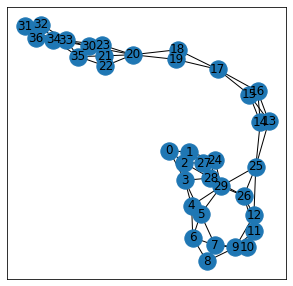

In [6]:
idx = 0
visualize(G[idx])

In [16]:
#Gram Matrix for the Weisfeiler-Lehman subtree kernel
iterations = 5
gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_wl{iterations}.csv"))
gram = aux.normalize_gram_matrix(gram)

### KernelPCA

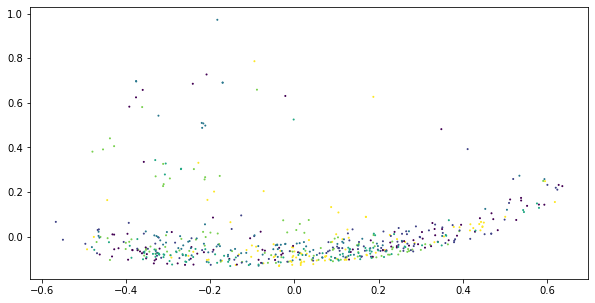

In [17]:
kpca = KernelPCA(n_components=100, kernel="precomputed")
reduced_kpca = kpca.fit_transform(gram)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(reduced_kpca[:,0], reduced_kpca[:,1], c=classes, s=1)
plt.show()

#### There seem to be outliers (although not sure as they might not look like outliers in another dimension) and this can have an effect on the effectiveness of the K-Means.

In [8]:
import csv

with open('gram.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for l in gram:
        writer.writerow(l)

### TruncatedSVD

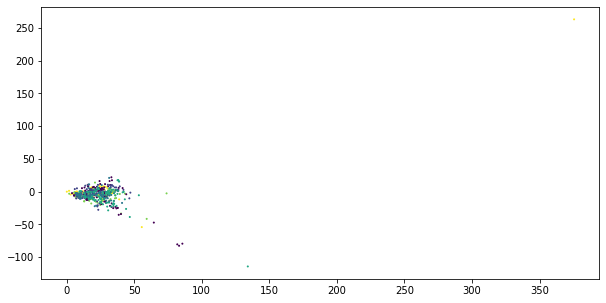

In [13]:
#Gram Matrix for the Weisfeiler-Lehman subtree kernel
iterations = 5
vec = load_sparse(os.path.join(base_path,f"{ds_name}_vectors_wl{iterations}.npz"))
tsvd = TruncatedSVD(n_components=100)
reduced_tsvd = tsvd.fit_transform(vec)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(reduced_tsvd[:,0], reduced_tsvd[:,1], c=classes, s=1)
plt.show()

#### More outliers can be seen here. 

### Subkmeans with KernelPCA

In [14]:
k = len(set(classes.tolist()))
print("n_clusters: ", k)
nrkm = NrKmeans(n_clusters=[k,1], allow_larger_noise_space=True)
nrkm.fit(reduced_kpca, best_of_n_rounds=10, verbose=False)
print("Found Cluster Subspaces: ", nrkm.m)
subkm_nmi = normalized_mutual_info_score(nrkm.labels[0],classes)
print(f"Subkmeans NMI:{subkm_nmi:.4f}")  

n_clusters:  6
Found Cluster Subspaces:  [5, 95]
Subkmeans NMI:0.0854


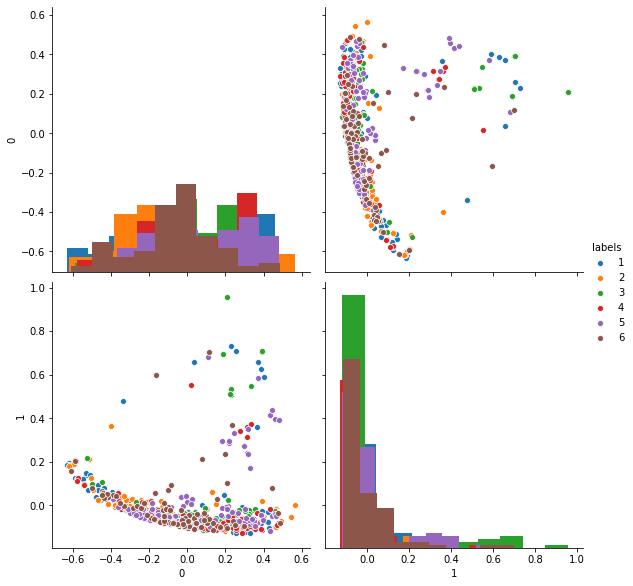

In [15]:
V = nrkm.V
rotated = np.dot(reduced_kpca,V)
reduced_df = pd.DataFrame(rotated[:,0:2])
reduced_df["labels"] = classes
sns.pairplot(reduced_df, hue="labels", diag_kind="hist", height=4)
plt.show();

### Cluster Analysis with KMeans

In [22]:
costs = []
kmeans_runs = []
k_list = [1, 2 , 5, 8, 10, 15, 20, 25, 30, 35, 40]
for k in k_list:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_kpca)
    costs.append(kmeans.inertia_)
    kmeans_runs.append(deepcopy(kmeans))
    

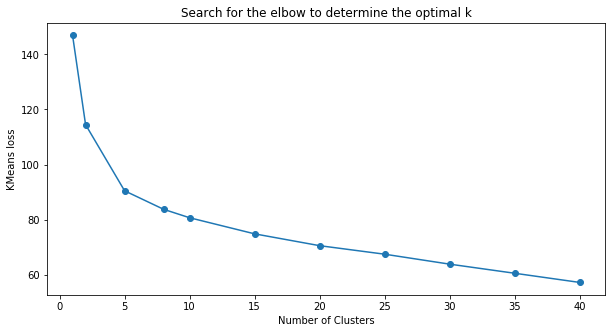

In [23]:
def scree_plot(k_list, costs):
    plt.figure(figsize=(10,5))
    plt.plot(k_list, costs, marker="o")
    plt.xlabel('Number of Clusters')
    plt.ylabel('KMeans loss')
    plt.title('Search for the elbow to determine the optimal k')
    plt.show();
scree_plot(k_list, costs)

#### Optimal K = 5

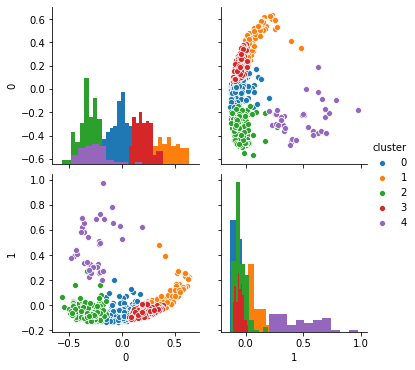

In [27]:
selected_idx = 2
kmeans = kmeans_runs[selected_idx]
df = pd.DataFrame(reduced_kpca[:,0:2])
df["cluster"] = kmeans.labels_
sns.pairplot(df, hue="cluster", diag_kind="hist")
plt.show()
